In [1]:
# Import necessary libraries
import pandas as pd
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/data.csv', sep=',')

In [3]:
#df has strings, turn everything lowercase
df = df.apply(lambda x: x.astype(str).str.lower())
df.head()

,angles,catala,espanyol,alemany,frances,polones,portugues,romanes,italia,suec
0,as,com,como,wie,comme,jak,como,la fel de,come,kama
1,his,seva,su,seine,le sien,jego,seu,a lui,il suo,yake
2,that,que,que,das,ce,że,este,acea,quello,hiyo
3,he,ell,él,er,il,on,ele,el,lui,yeye
4,was,era,estaba,war,a été,był,foi,a fost,era,alikuwa


In [4]:
#languages = ['angles', 'catala', 'espanyol', 'alemany', 'frances', 'polones', 'portugues', 'romanes', 'italia', 'suec']
dfs = list()
for lang in df.columns:
    if lang == 'angles' or lang == 'catala':
        df_lang = pd.DataFrame(df[lang])
        df_lang['lang'] = lang[:3]
        df_lang = df_lang.rename(columns={lang: 'word'})
        dfs.append(df_lang)
df2 = pd.concat(dfs, ignore_index=True)

In [5]:
df2.head()

,word,lang
0,as,ang
1,his,ang
2,that,ang
3,he,ang
4,was,ang


## Feature Engineering

In [6]:
def count_special_characters(word: str, string: str) -> int:
    num_special_characters=0
    for char in word:
        if char in string:
            num_special_characters+=1
    return num_special_characters

In [7]:
def has_suffix(word: str, suffixes: list) -> int:
    for suffix in suffixes:
        if word.endswith(suffix):
            return 1
    return 0

In [8]:
def has_prefix(word: str, prefixes: list) -> int:
    for prefix in prefixes:
        if word.startswith(prefix):
            return 1
    return 0

In [9]:
# Length
df2['len'] = df2['word'].str.len()

dict = {'vow':'aeiouAEIOU', 'acc':'àèìòùÀÈÌÒÙáéíóúÁÉÍÓÚ', 'accl':'àèìòùÀÈÌÒÙ', 'accr':'áéíóúÁÉÍÓÚ', 'die':'äëïöüÄËÏÖÜ',
       'ç':'çÇ'}


prefix = {
        'pre_eng': ["anti", "be", "de", "dis", "en", "ex", "im", "in", "non", "pre", "re", "un"],
        'pre_esp_cat': ["anti", "auto", "contra", "des", "en", "ex", "in", "inter", "pre", "re", "sub", "trans"],

}

suffix = {
        'suf_eng': ["able", "al", "ation", "er", "est", "ful", "ing", "ion", "ive", "less", "ly", "ness", "ous", "s", "y"],
        'suf_esp_cat': ["ado", "ador", "aje", "anza", "ar", "ario", "ero", "iente", "illa", "ina", "izar", "oso", "ón", "udo"],
       
}

for column in dict:
        df2[column] = df2['word'].apply(lambda row: count_special_characters(row, dict[column]))

for column in prefix:
        df2[column] = df2['word'].apply(lambda row: has_prefix(row, prefix[column]))

for column in suffix:
        df2[column] = df2['word'].apply(lambda row: has_suffix(row, suffix[column]))

In [10]:
df2.head()

,word,lang,len,vow,acc,accl,accr,die,ç,pre_eng,pre_esp_cat,suf_eng,suf_esp_cat
0,as,ang,2,1,0,0,0,0,0,0,0,1,0
1,his,ang,3,1,0,0,0,0,0,0,0,1,0
2,that,ang,4,1,0,0,0,0,0,0,0,0,0
3,he,ang,2,1,0,0,0,0,0,0,0,0,0
4,was,ang,3,1,0,0,0,0,0,0,0,1,0


In [12]:
X = df2[['len', 'vow', 'acc', 'accl', 'accr', 'die', 'ç', 'pre_eng', 'pre_esp_cat', 'suf_eng', 'suf_esp_cat']]
y = df2['lang']

# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# Split the data into training, testing and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2)

# Define the SVM model
model1 = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2 = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3 = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1

model1_pca = svm.SVC(kernel='linear', probability=True)  # linear kernel
model2_pca = svm.SVC(kernel='poly', degree=3, probability=True)  # polynomial kernel with degree 3
model3_pca = svm.SVC(kernel='rbf', gamma=0.1, probability=True)  # RBF kernel with gamma = 0.1


In [13]:
# Train the models on the training data
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

model1_pca.fit(X_train_pca, y_train_pca)
model2_pca.fit(X_train_pca, y_train_pca)
model3_pca.fit(X_train_pca, y_train_pca)

SVC(gamma=0.1, probability=True)

In [14]:
# Evaluate the models on the test data
score1 = model1.score(X_test, y_test)
score2 = model2.score(X_test, y_test)
score3 = model3.score(X_test, y_test)
print(f'Model 1 accuracy: {score1 * 100}%')
print(f'Model 2 accuracy: {score2 * 100}%')
print(f'Model 3 accuracy: {score3 * 100}%\n')

# Evaluate the models on the test data
score1_pca = model1_pca.score(X_test_pca, y_test_pca)
score2_pca = model2_pca.score(X_test_pca, y_test_pca)
score3_pca = model3_pca.score(X_test_pca, y_test_pca)
print(f'Model 1 pca accuracy: {score1_pca * 100}%')
print(f'Model 2 pca accuracy: {score2_pca * 100}%')
print(f'Model 3 pca accuracy: {score3_pca * 100}%')

Model 1 accuracy: 70.70707070707071%
Model 2 accuracy: 66.91919191919192%
Model 3 accuracy: 68.43434343434343%

Model 1 pca accuracy: 68.93939393939394%
Model 2 pca accuracy: 63.38383838383839%
Model 3 pca accuracy: 67.42424242424242%


In [ ]:
# Use the trained models to make predictions
predictions1 = model1.predict_proba(X_test)
predictions2 = model2.predict_proba(X_test)
predictions3 = model3.predict_proba(X_test)

predictions1_pca = model1_pca.predict_proba(X_test_pca)
predictions2_pca = model2_pca.predict_proba(X_test_pca)
predictions3_pca = model3_pca.predict_proba(X_test_pca)

In [ ]:
print('Top 3 accuracy model 1 %f' % top_k_accuracy_score(y_test, predictions1, k=3))
print('Top 3 accuracy model 2 %f' % top_k_accuracy_score(y_test, predictions2, k=3))
print('Top 3 accuracy model 3 %f\n' % top_k_accuracy_score(y_test, predictions3, k=3))

print('accuracy model 1 pca %f' % top_k_accuracy_score(y_test_pca, predictions1_pca, k=3))
print('Top 3 accuracy model 2 pca %f' % top_k_accuracy_score(y_test_pca, predictions2_pca, k=3))
print('Top 3 accuracy model 3 pca %f' % top_k_accuracy_score(y_test_pca, predictions3_pca, k=3))



Top 3 accuracy model 1 0.573887
Top 3 accuracy model 2 0.559211
Top 3 accuracy model 3 0.567308

accuracy model 1 pca 0.538462
Top 3 accuracy model 2 pca 0.509615
Top 3 accuracy model 3 pca 0.556680


In [ ]:
# Generate classification reports for the models
print(classification_report(y_test, model1.predict(X_test), zero_division=0))
print(classification_report(y_test, model2.predict(X_test), zero_division=0))
print(classification_report(y_test, model3.predict(X_test), zero_division=0))

print(classification_report(y_test_pca, model1_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model2_pca.predict(X_test_pca), zero_division=0))
print(classification_report(y_test_pca, model3_pca.predict(X_test_pca), zero_division=0))

              precision    recall  f1-score   support

         ale       0.25      0.28      0.27       190
         ang       0.20      0.65      0.31       203
         cat       0.56      0.05      0.09       215
         esp       0.33      0.06      0.11       187
         fra       0.48      0.13      0.21       181
         ita       0.25      0.39      0.30       194
         pol       0.96      0.45      0.61       199
         por       0.86      0.06      0.11       198
         rom       1.00      0.28      0.44       202
         sue       0.24      0.61      0.34       207

    accuracy                           0.30      1976
   macro avg       0.51      0.30      0.28      1976
weighted avg       0.51      0.30      0.28      1976

              precision    recall  f1-score   support

         ale       0.24      0.26      0.25       190
         ang       0.18      0.81      0.29       203
         cat       0.15      0.10      0.12       215
         esp       0.33 

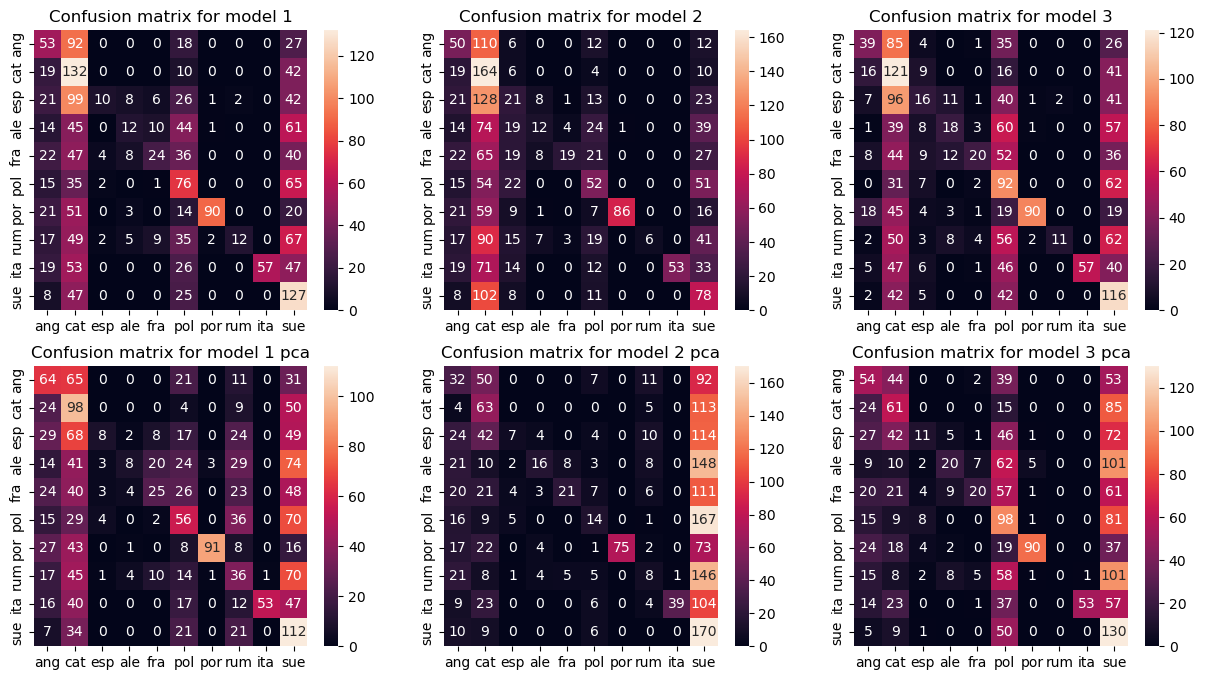

In [ ]:
# Generate confusion matrices for the models and plot them as heatmaps try to make them look pretty,you can use seaborn for this
cm1 = confusion_matrix(y_test, model1.predict(X_test))
cm2 = confusion_matrix(y_test, model2.predict(X_test))
cm3 = confusion_matrix(y_test, model3.predict(X_test))

cm1_pca = confusion_matrix(y_test_pca, model1_pca.predict(X_test_pca))
cm2_pca = confusion_matrix(y_test_pca, model2_pca.predict(X_test_pca))
cm3_pca = confusion_matrix(y_test_pca, model3_pca.predict(X_test_pca))

# Plot the confusion matrices
langs =["ang", "cat", "esp", "ale", "fra", "pol", "por", "rum", "ita", "sue"]
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

sns.heatmap(cm1, annot=True, ax=ax[0][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2, annot=True, ax=ax[0][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3, annot=True, ax=ax[0][2], fmt='d', xticklabels=langs, yticklabels=langs)

sns.heatmap(cm1_pca, annot=True, ax=ax[1][0], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm2_pca, annot=True, ax=ax[1][1], fmt='d', xticklabels=langs, yticklabels=langs)
sns.heatmap(cm3_pca, annot=True, ax=ax[1][2], fmt='d', xticklabels=langs, yticklabels=langs)

ax[0][0].set_title('Confusion matrix for model 1')
ax[0][1].set_title('Confusion matrix for model 2')
ax[0][2].set_title('Confusion matrix for model 3')

ax[1][0].set_title('Confusion matrix for model 1 pca')
ax[1][1].set_title('Confusion matrix for model 2 pca')
ax[1][2].set_title('Confusion matrix for model 3 pca')
plt.show()
